In [1]:
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
import random
import time
from PhyDNet.models.models_modified import ConvLSTM,PhyCell, EncoderRNN, ClassifierRNN
from tensorboardX import SummaryWriter
from PhyDNet.data.moving_mnist import MovingMNIST
from PhyDNet.constrain_moments import K2M
import argparse
from tqdm import tqdm
import os
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import pandas as pd
import confinement_mode_classifier as cmc
from datetime import datetime
import PhyDNet_COMPASS as pdnc

In [2]:
batch_size=32
eval_every=1
print_every=1
nepochs=20
data_range = 1.0 # data range 0 to 1 - images normalized this way
root='PhyDNet/data/'
timestamp = datetime.fromtimestamp(time.time()).strftime("%y-%m-%d, %H-%M-%S ")
save_name = timestamp + ' phydnet'


In [3]:


path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


#### Create dataloaders ########################################
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_ris1']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shot_numbers, shots_for_training, shots_for_testing, 
                                                                shots_for_validation, use_ELMS=3, ris_option='RIS1', use_for_PhyDNet=True)

In [4]:
#Read article, see PhyDNet/constrain_moments.py
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1   

In [5]:
train_dset = pdnc.ImagesDataset(train_df, path, gray_scale=True, n_frames_input=5,n_frames_output=4)
test_dset = pdnc.ImagesDataset(test_df, path, gray_scale=True, n_frames_input=5,n_frames_output=4)

train_loader = DataLoader(train_dset, batch_size=3, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dset, batch_size=3, shuffle=False, num_workers=0)

In [6]:
num_batches = len(train_loader)
print("Number of batches in train_loader:", num_batches)


Number of batches in train_loader: 16257


In [7]:
next(iter(train_loader))['imgs_target'].shape

torch.Size([3, 5, 1, 352, 352])

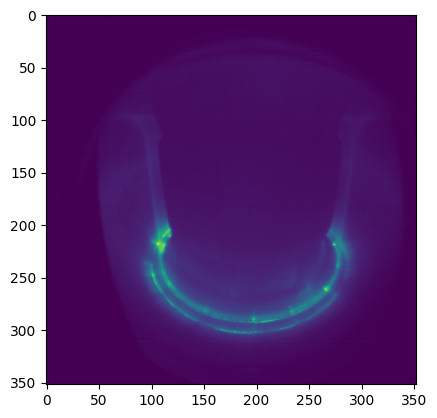

In [8]:
import matplotlib.pyplot as plt
img = next(iter(train_loader))['imgs_input'][0][0]

plt.imshow(img.permute(1,2,0).cpu().numpy())

In [9]:

phycell  =  PhyCell(input_shape=(88,88), input_dim=352, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convcell =  ConvLSTM(input_shape=(88,88), input_dim=352, hidden_dims=[8,8,352], n_layers=3, kernel_size=(3,3), device=device)   
encoder  = EncoderRNN(phycell, convcell, device)

layer  0 input dim  352  hidden dim  8
layer  1 input dim  8  hidden dim  8
layer  2 input dim  8  hidden dim  352


In [10]:

classifier = ClassifierRNN(phycell, convcell, device)

In [11]:
a = next(iter(train_loader))['imgs_input'][:,2,:,:,:]
b = next(iter(train_loader))['imgs_input'][:,1,:,:,:]

In [12]:
torch

<module 'torch' from '/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torch/__init__.py'>

In [13]:
sample_input =next(iter(train_loader))['imgs_input'][:,2,:,:,:]

In [15]:

classifier(sample_input, (True))

torch.Size([3, 8, 88, 88])
torch.Size([3, 8, 88, 88])
torch.Size([3, 352, 88, 88])


RuntimeError: stack expects each tensor to be equal size, but got [3, 8, 88, 88] at entry 0 and [3, 352, 88, 88] at entry 2

In [17]:
from torchsummary import summary
summary(encoder, input_size=(5, 1, 352, 352))

Layer (type:depth-idx)                        Param #
├─encoder_E: 1-1                              --
|    └─dcgan_conv: 2-1                        --
|    |    └─Sequential: 3-1                   2,112
|    └─dcgan_conv: 2-2                        --
|    |    └─Sequential: 3-2                   279,312
|    └─dcgan_conv: 2-3                        --
|    |    └─Sequential: 3-3                   558,624
├─encoder_specific: 1-2                       --
|    └─dcgan_conv: 2-4                        --
|    |    └─Sequential: 3-4                   1,116,192
|    └─dcgan_conv: 2-5                        --
|    |    └─Sequential: 3-5                   1,116,192
├─encoder_specific: 1-3                       --
|    └─dcgan_conv: 2-6                        --
|    |    └─Sequential: 3-6                   1,116,192
|    └─dcgan_conv: 2-7                        --
|    |    └─Sequential: 3-7                   1,116,192
├─decoder_specific: 1-4                       --
|    └─dcgan_upconv: 2-

Layer (type:depth-idx)                        Param #
├─encoder_E: 1-1                              --
|    └─dcgan_conv: 2-1                        --
|    |    └─Sequential: 3-1                   2,112
|    └─dcgan_conv: 2-2                        --
|    |    └─Sequential: 3-2                   279,312
|    └─dcgan_conv: 2-3                        --
|    |    └─Sequential: 3-3                   558,624
├─encoder_specific: 1-2                       --
|    └─dcgan_conv: 2-4                        --
|    |    └─Sequential: 3-4                   1,116,192
|    └─dcgan_conv: 2-5                        --
|    |    └─Sequential: 3-5                   1,116,192
├─encoder_specific: 1-3                       --
|    └─dcgan_conv: 2-6                        --
|    |    └─Sequential: 3-6                   1,116,192
|    └─dcgan_conv: 2-7                        --
|    |    └─Sequential: 3-7                   1,116,192
├─decoder_specific: 1-4                       --
|    └─dcgan_upconv: 2-

In [12]:

trained_enc = pdnc.trainIters(encoder,nepochs, print_every=1, eval_every=1, 
                              name=save_name, device=device, train_loader=train_loader, 
                              test_loader=test_loader, batch_size=1, data_range=1.0, 
                              constraints=constraints, writer=writer)

train:   1%|          | 103/16257 [01:53<4:56:26,  1.10s/it]


KeyboardInterrupt: 

: 